In [35]:
import pandas as pd, numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt
import nltk
import re
import seaborn as sns

In [36]:
file_path = '/content/drive/MyDrive/moj_data_new.csv'  # Replace with your actual file path
df = pd.read_csv(file_path)

# Sentiment Analysis

In [37]:
def convert_counts(count):
    count = str(count).lower()
    if 'k' in count:
        return int(float(count.replace('k', '')) * 1000)
    elif 'm' in count:
        return int(float(count.replace('m', '')) * 1000000)
    else:
        return int(count)  # For numbers without suffix

# Function to analyze sentiment
def analyze_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity  # Range: -1 (negative) to +1 (positive)

# Preprocess: Convert 'Likes' and 'Shares' to numerical format
df['Likes'] = df['Likes'].apply(convert_counts)
df['Shares'] = df['Shares'].apply(convert_counts)

# Apply sentiment analysis to the 'English' column
df['Sentiment'] = df['English'].apply(lambda x: analyze_sentiment(str(x)))

# Categorize sentiment
def categorize_sentiment(score):
    if score > 0.1:
        return 'Positive'
    elif score < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

df['Sentiment Category'] = df['Sentiment'].apply(categorize_sentiment)

# # Save processed df to a new file
# output_file = '/content/drive/MyDrive/final_processed_data.csv'
# df.to_csv(output_file, index=False)
# print(f"Data preprocessing and sentiment analysis complete. Results saved in '{output_file}'.")

df.head()

,Likes,Comments,Shares,Content,Audio URL,Transcription,English,Unnamed: 7,Sentiment,Sentiment Category
0,216800,131,73300,poster,https://cdn4.sharechat.com/2f3639fb_1700986341...,प्रश्न प्रश्न प्रश्न प्रश्न प्रश्न प्रश्न प्र...,Question Question Question Question Question Q...,Question Question Question Question Question Q...,0.00,Neutral
1,58700,115,9600,#NIVEASoftBeautyChallenge #AageBadhJa #ShubhDh...,https://cdn4.sharechat.com/33d5318_26f/audio/3...,और मिलो या ना मिलो हम आपके हैं मिलो ना मिलो ह...,"And meet or not meet, we are yours, do not mee...","And meet or not meet, we are yours, do not mee...",0.00,Neutral
2,104100,197,9600,poster,https://cdn4.sharechat.com/33d5318_26f/audio/4...,तू दूर नहोना शम्द मैं किसी आओ,"You are not far away, I come to someone","You are not far away, I come to someone",-0.05,Neutral
3,95700,65,15900,#TopGiftedVideos,https://cdn4.sharechat.com/33d5318_26f/audio/5...,सबसे भरोसेमन्द इनसान ही दोका देता है ये आज से...,The most trusted person gives it that it is ru...,The most trusted person gives it that it is ru...,0.50,Positive
4,44900,126,9400,#NIVEASoftFashionChallenge,https://cdn4.sharechat.com/33d5318_26f/audio/4...,कर दो,Do it,Do it,0.00,Neutral


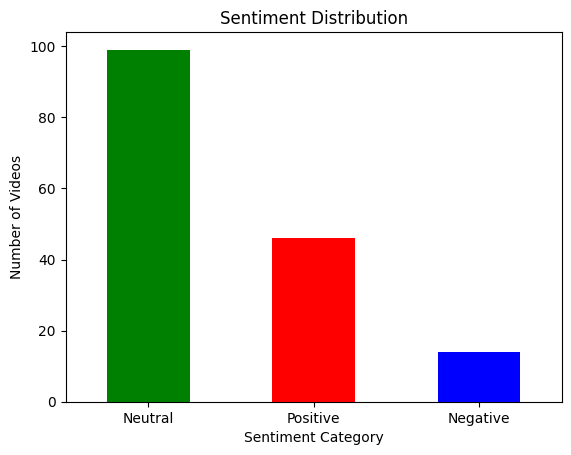

In [38]:
# Visualization (optional)
sentiment_counts = df['Sentiment Category'].value_counts()
sentiment_counts.plot(kind='bar', color=['green', 'red', 'blue'], title='Sentiment Distribution')
plt.xlabel('Sentiment Category')
plt.xticks(rotation=360)
plt.ylabel('Number of Videos')
plt.show()

# Content Categorization

In [39]:
df["Content"] = df["Content"].str.replace(r'\bposter\b', '', case=False, regex=True).str.strip()
df["Content"] = df["Content"].replace('', np.nan)

In [40]:
# def preprocess_hashtags(hashtags):
#     # Check if the input is a string before applying regex
#     if isinstance(hashtags, str):
#         hashtags = re.sub(r"#", " ", hashtags)  # Remove hashtags
#         hashtags = hashtags.lower().strip()  # Convert to lowercase and strip whitespace
#         hashtags = re.findall(r'\w+', hashtags)  # Extract words
#         return hashtags
#     # If not a string (e.g., NaN), return an empty list or a suitable placeholder
#     else:
#         return []  # Return an empty list for non-string values

# df["Processed_Hashtags"] = df["Content"].apply(preprocess_hashtags)

In [41]:
def preprocess_text(text):
    if isinstance(text, str):
        text = re.sub(r"#", " ", text)  # Remove hashtags
        text = text.lower().strip()  # Convert to lowercase and strip whitespace
        text = re.findall(r'\w+', text)  # Extract words
        return text
    else:
        return []

In [42]:
df["Processed_Hashtags"] = df["Content"].apply(preprocess_text)
df["Processed_Transcription"] = df["English"].apply(preprocess_text)

# Combine hashtags and transcription
df["Combined_Text"] = df.apply(
    lambda row: row["Processed_Hashtags"] + row["Processed_Transcription"], axis=1
)

In [43]:
from sentence_transformers import SentenceTransformer

# Load pre-trained sentence embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')

def generate_embeddings(text):
    if text:  # If there are text
        return model.encode(" ".join(text))
    else:  # Return None for empty lists
        return None

df["Combined_Embeddings"] = df["Combined_Text"].apply(generate_embeddings)

# Separate rows with valid embeddings from empty ones
valid_embeddings = df["Combined_Embeddings"].dropna().tolist()
empty_rows = df["Combined_Embeddings"].isna()

In [44]:
from sklearn.cluster import KMeans
import numpy as np

# Stack all embeddings
embeddings = np.vstack(valid_embeddings)

# Perform KMeans clustering
num_clusters = 9  # Choose a suitable number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df.loc[~empty_rows, "Category"] = kmeans.fit_predict(embeddings)

In [45]:
# Create a mapping of cluster IDs to general category names
category_mapping = {
    0: "love",
    1: "funny",
    2: "sad",
    3: "motivational",
    4: "travel",
    5: "festival",
    6: "cute",
    7: "fashion",
    8: "food"
}

df.loc[~empty_rows, "Generalized_Category"] = df.loc[~empty_rows, "Category"].map(category_mapping)

# Assign "unknown" to empty rows
df.loc[empty_rows, "Generalized_Category"] = "unknown"

In [46]:
df.drop(columns="Unnamed: 7", inplace=True)
df.columns

Index(['Likes', 'Comments', 'Shares', 'Content', 'Audio URL', 'Transcription',
       'English', 'Sentiment', 'Sentiment Category', 'Processed_Hashtags',
       'Processed_Transcription', 'Combined_Text', 'Combined_Embeddings',
       'Category', 'Generalized_Category'],
      dtype='object')

In [47]:
df.to_csv("/content/drive/MyDrive/updated_moj2.csv", index=False)

<ipython-input-48-aa77a7e858d8>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=filtered_df, x="Generalized_Category", palette='bright')


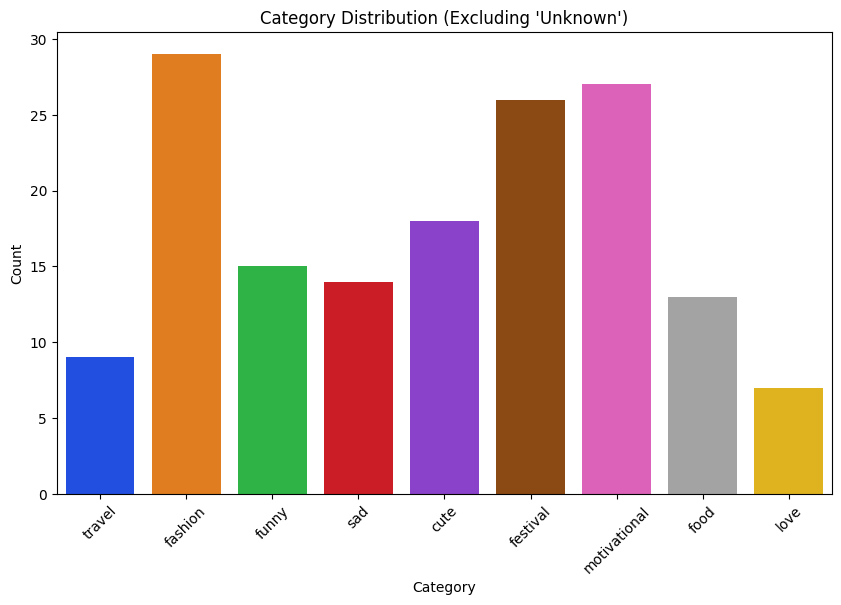

In [48]:
filtered_df = df[df["Generalized_Category"] != "unknown"]

# Example: Plot a bar chart of category counts
category_counts = filtered_df["Generalized_Category"].value_counts()

# Plot the data
plt.figure(figsize=(10, 6))
sns.countplot(data=filtered_df, x="Generalized_Category", palette='bright')
plt.title("Category Distribution (Excluding 'Unknown')")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()